In [19]:
import os
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import glob
import pickle
import pathlib
from PIL import Image
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from tensorflow import keras
from keras.models import *
from keras.layers import *
from tensorflow.keras.optimizers.legacy import Adam
from keras import backend as keras
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
from tensorflow.keras.activations import *

from keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping, ReduceLROnPlateau
from datetime import datetime

In [2]:
images_dir_path='Normal/chest_x_ray'
masks_dir_path='Normal/chest_x_ray_masks'

images_dir=os.listdir(images_dir_path)
masks_dir=os.listdir(masks_dir_path)

print("="*32+"\nTotal number of Images : ",len(images_dir))
print("="*32+"\nTotal number of Masks : ",len(masks_dir))

Total number of Images :  1001
Total number of Masks :  1001


In [3]:
SEED = 42
np.random.seed(SEED)
tf.random.set_seed(SEED)

In [4]:
images_path=[]

for i in range(len(images_dir)):
#     temp_path=os.path.join(images_dir_path, images_dir[i])
    temp_path=images_dir_path+"/"+images_dir[i]
#     print(temp_path)
    images_path.append(temp_path)
    
masks_path=[]

for i in range(len(masks_dir)):
#     temp_mask=os.path.join(masks_dir_path, masks_dir[i])
    temp_mask=masks_dir_path+"/"+masks_dir[i]
    masks_path.append(temp_mask)



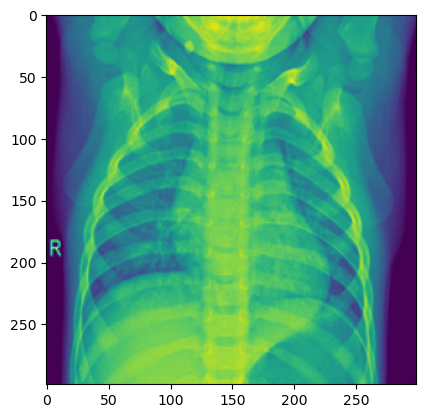

In [5]:
plt.imshow(plt.imread(images_path[0]))

In [6]:
img_row = 256
img_col = 256
img_chan = 3
target_shape = (img_row, img_col, img_chan)
num_imgs=len(images_path)

images=np.zeros((num_imgs, img_row, img_col))
masks=np.zeros_like(images)

In [7]:
def load_imgs_masks(DIR, array):
    
    for i in range(len(DIR)):
        temp_img=image.load_img(DIR[i], target_size=target_shape)
        img=image.img_to_array(temp_img)
        array[i]=img[:,:,0]/255.0
        
    array=np.expand_dims(array, axis=3)
    return array  

In [8]:
images=load_imgs_masks(images_path, images)
masks=load_imgs_masks(masks_path, masks)

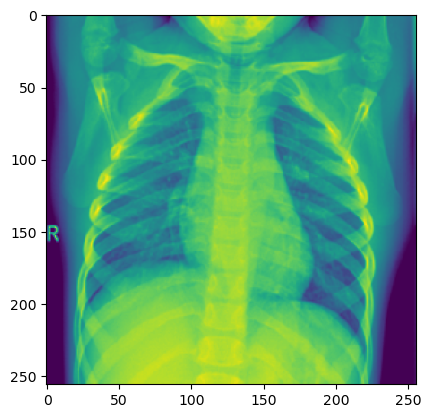

In [9]:
# plt.imshow(images[np.random.randint(0,3616)])
# plt.show()
#create data of shape (256,256,1)
data = images[np.random.randint(0,2113)]*256
im = data.astype(np.uint8)
im.shape
 # prints (256L, 256L, 1L)
# (256,256,1) cannot be plotted, therefore 
# we need to get rid of the last dimension:
im = im[:,:,0]
im.shape # (256L, 256L)
# now the image can be plotted
plt.imshow(im)
plt.show()

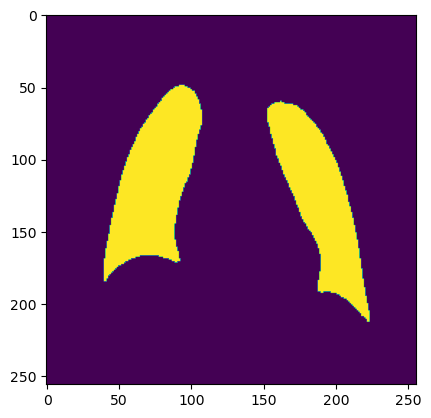

In [10]:
# plt.imshow(images[np.random.randint(0,501)])
# plt.show()
#create data of shape (256,256,1)
data = masks[np.random.randint(0,501)]
im = data.astype(np.uint8)
im.shape
 # prints (256L, 256L, 1L)
# (256,256,1) cannot be plotted, therefore 
# we need to get rid of the last dimension:
im = im[:,:,0]
im.shape # (256L, 256L)
# now the image can be plotted
plt.imshow(im)
plt.show()

In [11]:
train_images, test_images, train_masks, test_masks = train_test_split(images, masks, test_size=0.2, random_state=SEED)

In [12]:
def dice_coef(y_true, y_pred):
    y_true_f = keras.flatten(y_true)
    y_pred_f = keras.flatten(y_pred)
    intersection = keras.sum(y_true_f * y_pred_f)
    return (2. * intersection + 1) / (keras.sum(y_true_f) + keras.sum(y_pred_f) + 1)

def dice_coef_loss(y_true, y_pred):
    return -dice_coef(y_true, y_pred)

In [13]:
def build_model(start_neurons):

    input_layer = Input((256, 256, 1))

    conv1 = Conv2D(start_neurons * 1, (3, 3), activation="relu", padding="same")(input_layer)
    conv1 = Conv2D(start_neurons * 1, (3, 3), activation="relu", padding="same")(conv1)
    pool1 = MaxPooling2D((2, 2))(conv1)
    pool1 = Dropout(0.25)(pool1)

    conv2 = Conv2D(start_neurons * 2, (3, 3), activation="relu", padding="same")(pool1)
    conv2 = Conv2D(start_neurons * 2, (3, 3), activation="relu", padding="same")(conv2)
    pool2 = MaxPooling2D((2, 2))(conv2)
    pool2 = Dropout(0.5)(pool2)

    conv3 = Conv2D(start_neurons * 4, (3, 3), activation="relu", padding="same")(pool2)
    conv3 = Conv2D(start_neurons * 4, (3, 3), activation="relu", padding="same")(conv3)
    pool3 = MaxPooling2D((2, 2))(conv3)
    pool3 = Dropout(0.5)(pool3)

    conv4 = Conv2D(start_neurons * 8, (3, 3), activation="relu", padding="same")(pool3)
    conv4 = Conv2D(start_neurons * 8, (3, 3), activation="relu", padding="same")(conv4)
    pool4 = MaxPooling2D((2, 2))(conv4)
    pool4 = Dropout(0.5)(pool4)

    # Middle
    convm = Conv2D(start_neurons * 16, (3, 3), activation="relu", padding="same")(pool4)
    convm = Conv2D(start_neurons * 16, (3, 3), activation="relu", padding="same")(convm)
    
    deconv4 = Conv2DTranspose(start_neurons * 8, (3, 3), strides=(2, 2), padding="same")(convm)
    uconv4 = concatenate([deconv4, conv4])
    uconv4 = Dropout(0.5)(uconv4)
    uconv4 = Conv2D(start_neurons * 8, (3, 3), activation="relu", padding="same")(uconv4)
    uconv4 = Conv2D(start_neurons * 8, (3, 3), activation="relu", padding="same")(uconv4)

    deconv3 = Conv2DTranspose(start_neurons * 4, (3, 3), strides=(2, 2), padding="same")(uconv4)
    uconv3 = concatenate([deconv3, conv3])
    uconv3 = Dropout(0.5)(uconv3)
    uconv3 = Conv2D(start_neurons * 4, (3, 3), activation="relu", padding="same")(uconv3)
    uconv3 = Conv2D(start_neurons * 4, (3, 3), activation="relu", padding="same")(uconv3)

    deconv2 = Conv2DTranspose(start_neurons * 2, (3, 3), strides=(2, 2), padding="same")(uconv3)
    uconv2 = concatenate([deconv2, conv2])
    uconv2 = Dropout(0.5)(uconv2)
    uconv2 = Conv2D(start_neurons * 2, (3, 3), activation="relu", padding="same")(uconv2)
    uconv2 = Conv2D(start_neurons * 2, (3, 3), activation="relu", padding="same")(uconv2)

    deconv1 = Conv2DTranspose(start_neurons * 1, (3, 3), strides=(2, 2), padding="same")(uconv2)
    uconv1 = concatenate([deconv1, conv1])
    uconv1 = Dropout(0.5)(uconv1)
    uconv1 = Conv2D(start_neurons * 1, (3, 3), activation="relu", padding="same")(uconv1)
    uconv1 = Conv2D(start_neurons * 1, (3, 3), activation="relu", padding="same")(uconv1)
    
    output_layer = Conv2D(1, (1,1), padding="same", activation="sigmoid")(uconv1)
    
    model=Model(inputs=input_layer, outputs=output_layer)

    return model

In [14]:
model=build_model(16)

Metal device set to: Apple M1 Pro

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB



2023-01-02 22:02:02.920592: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-01-02 22:02:02.920941: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [15]:
EPOCHS = 15
model.compile(optimizer=Adam(learning_rate=5*1e-4), loss="binary_crossentropy", 
                  metrics=[dice_coef, 'binary_accuracy'])
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 256, 256, 16  160         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 conv2d_1 (Conv2D)              (None, 256, 256, 16  2320        ['conv2d[0][0]']                 
                                )                                                             

In [16]:
weight_path="{}_weights.best.hdf5".format('cxr_reg')

checkpoint = ModelCheckpoint(weight_path, monitor='loss', #verbose=1, 
                             save_best_only=True, #mode='min', 
                             save_weights_only = True)


early = EarlyStopping(monitor="loss", 
                      #mode="min", 
                      patience=10) # probably needs to be more patient, but kaggle time is limited
callbacks_list = [checkpoint, early]
earlystopping = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=10)

In [17]:
curr_time=datetime.now()
print("Starting time : ", datetime.now())
history = model.fit(x = train_images, 
                    y = train_masks, 
                    validation_data = (test_images, test_masks), 
                    epochs = 30,
                    batch_size = 16,
                   callbacks = callbacks_list)
time_now=datetime.now()
print("Ending time : ", time_now)
print("="*40+"Time taken : ", time_now-curr_time)
model.save('my_model.h5')

Starting time :  2023-01-02 22:02:23.736422
Epoch 1/30


2023-01-02 22:02:24.128602: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2023-01-02 22:02:24.813787: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


46/50 [==========================>...] - ETA: 0s - loss: 0.5279 - dice_coef: 0.2583 - binary_accuracy: 0.7774

KeyboardInterrupt: 

In [18]:
model.evaluate(test_images, test_masks)

7/7 [==============================] - 1s 98ms/step - loss: 0.0344 - dice_coef: 0.9574 - binary_accuracy: 0.9870


[0.034448519349098206, 0.9573969841003418, 0.9869557023048401]

In [27]:
# import cv2
# def calc_area(img_num):
#     img=test_masks[img_num].reshape(1,256,256,1)
#     plt.show(img)

1/1 [==============================] - 0s 11ms/step


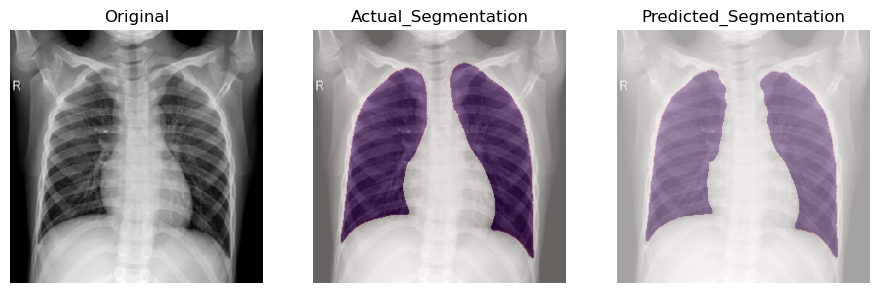

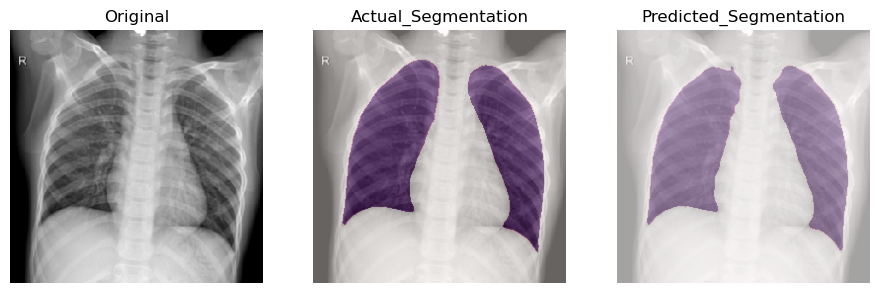

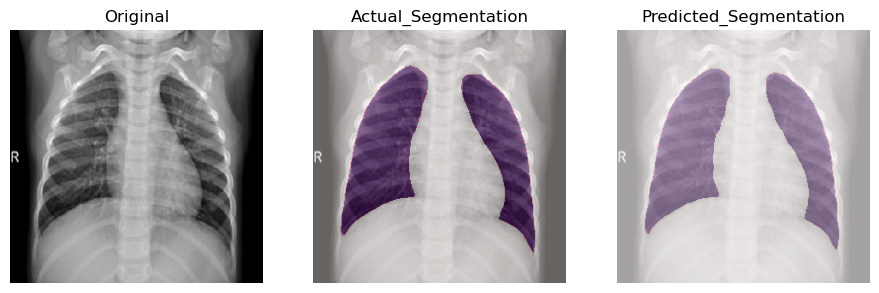

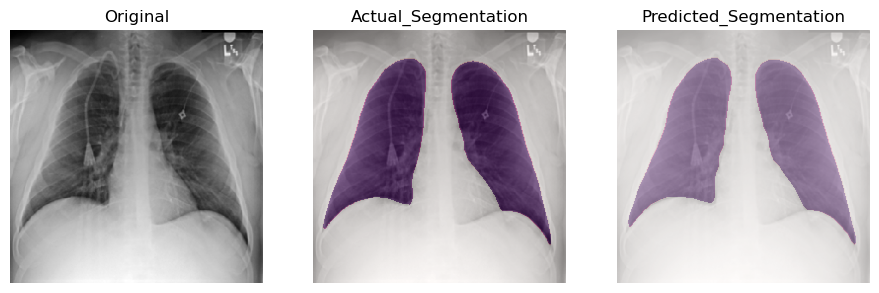

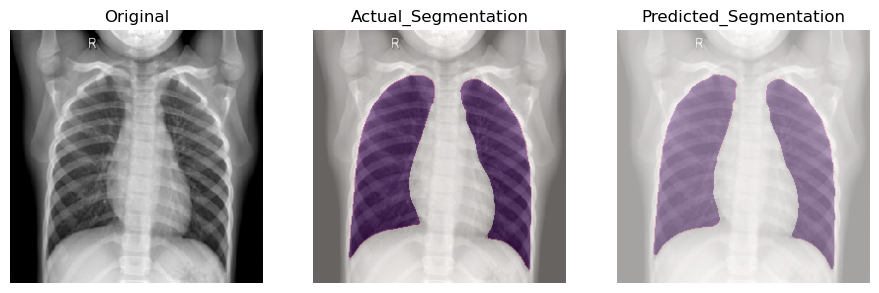

In [36]:
def test_on_image(model, img_array, img_num, img_side_size = 256):
    
    pred = model.predict(img_array[img_num].reshape(1,img_side_size,img_side_size,1))
    pred[pred>0.5] = 1.0
    pred[pred<0.5] = 0.0
    fig = plt.figure(figsize = (15,10))
    
    
    plt.subplot(1,4,1)
    plt.imshow(img_array[img_num].reshape(img_side_size, img_side_size), cmap = "gray")
    plt.title("Original")
    plt.axis("off")
    
    plt.subplot(1,4,2)
    plt.imshow(test_masks[img_num].reshape(img_side_size, img_side_size), cmap = "RdPu", alpha = 1)
    plt.imshow(img_array[img_num].reshape(img_side_size, img_side_size),cmap = "gray", alpha = 0.6)
    plt.title("Actual_Segmentation")
    plt.axis("off")
    
    plt.subplot(1,4,3)
    plt.imshow(img_array[img_num].reshape(img_side_size, img_side_size), cmap = "gray", alpha = 0.5)
    plt.imshow(pred.reshape(img_side_size, img_side_size),cmap = "RdPu", alpha = 0.3)
    plt.title("Predicted_Segmentation")
    plt.axis("off")
    
    
    return pred

def dice_coef_test(y_true, y_pred):
    y_true_f = y_true.flatten()
    y_pred_f = y_pred.flatten()
    union = np.sum(y_true_f) + np.sum(y_pred_f)
    if union==0: return 1
    intersection = np.sum(y_true_f * y_pred_f)
    return 2. * intersection / union

for i in range(5):
    IMG_NUM = np.random.randint(0,200) #Melhor img_num 12 (0.98) Pior img_num 10 (0.9)
    prediction = test_on_image(model, img_array = test_images, img_num = IMG_NUM, img_side_size = 256)
    dice_coef_test(y_true = test_masks[IMG_NUM], y_pred = prediction)
#     calc_area(IMG_NUM)
    

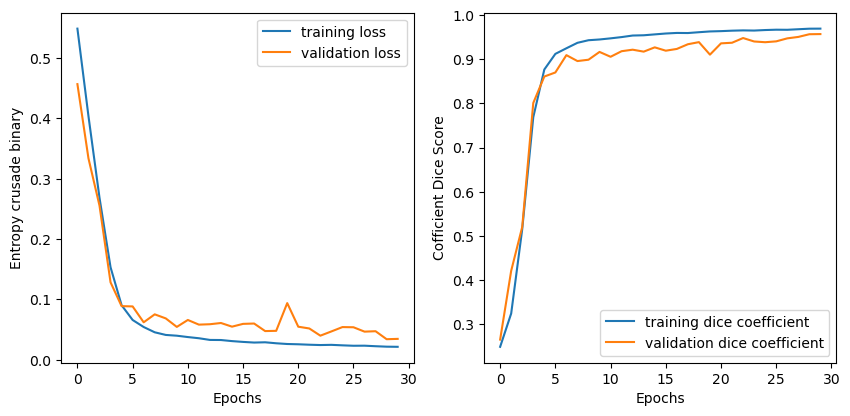

In [29]:
def get_metrics(history):
    fig = plt.figure(figsize = (10,10))
    plt.subplot(2,2,1)
    plt.plot(history.history["loss"], label = "training loss")
    plt.plot(history.history["val_loss"], label = "validation loss")
    plt.legend()
    plt.xlabel("Epochs")
    plt.ylabel("Entropy crusade binary")

    plt.subplot(2,2,2)
    plt.plot(history.history["dice_coef"], label = "training dice coefficient")
    plt.plot(history.history["val_dice_coef"], label = "validation dice coefficient")
    plt.legend()
    plt.xlabel("Epochs")
    plt.ylabel("Cofficient Dice Score")
    
get_metrics(history = history)

In [30]:
history.history.keys()

dict_keys(['loss', 'dice_coef', 'binary_accuracy', 'val_loss', 'val_dice_coef', 'val_binary_accuracy'])